In [1]:
# Load required libraries
library(tidyverse)
library(janitor)
library(dplyr)
library(ggplot2)
library(skimr)
library(purrr)
library(lubridate)

# Source helper scripts
source("../../R/apply_factors.R")
source("../../R/analysis_helpers.R")
source("../../R/temporal_helpers.R")

# Load data
tables <- list(
  Orders  = readr::read_csv("../../data/processed/Orders.csv"),
  Returns = readr::read_csv("../../data/processed/Returns.csv"),
  People  = readr::read_csv("../../data/processed/People.csv")
)

# Apply factor transformations
tables <- apply_factors(tables)

# Extract tables
orders  <- tables$Orders
returns <- tables$Returns
people  <- tables$People

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Rows: 51290 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (13): order_id, ship_mode, customer_name, segment, state, country, mark...
dbl   (6): sales, quantity, discount, profit, shipping_cost, year
date  (2): order_date, ship_date

ℹ Use `spec()` to retrieve the full column specification f

In [2]:
options(repr.plot.width = 14, repr.plot.height = 5)
orders_monthly <- orders |>  mutate(month = floor_date(order_date, "month"))

# Executive Time Snapshot

### Total sales & profit over time (monthly aggregation)

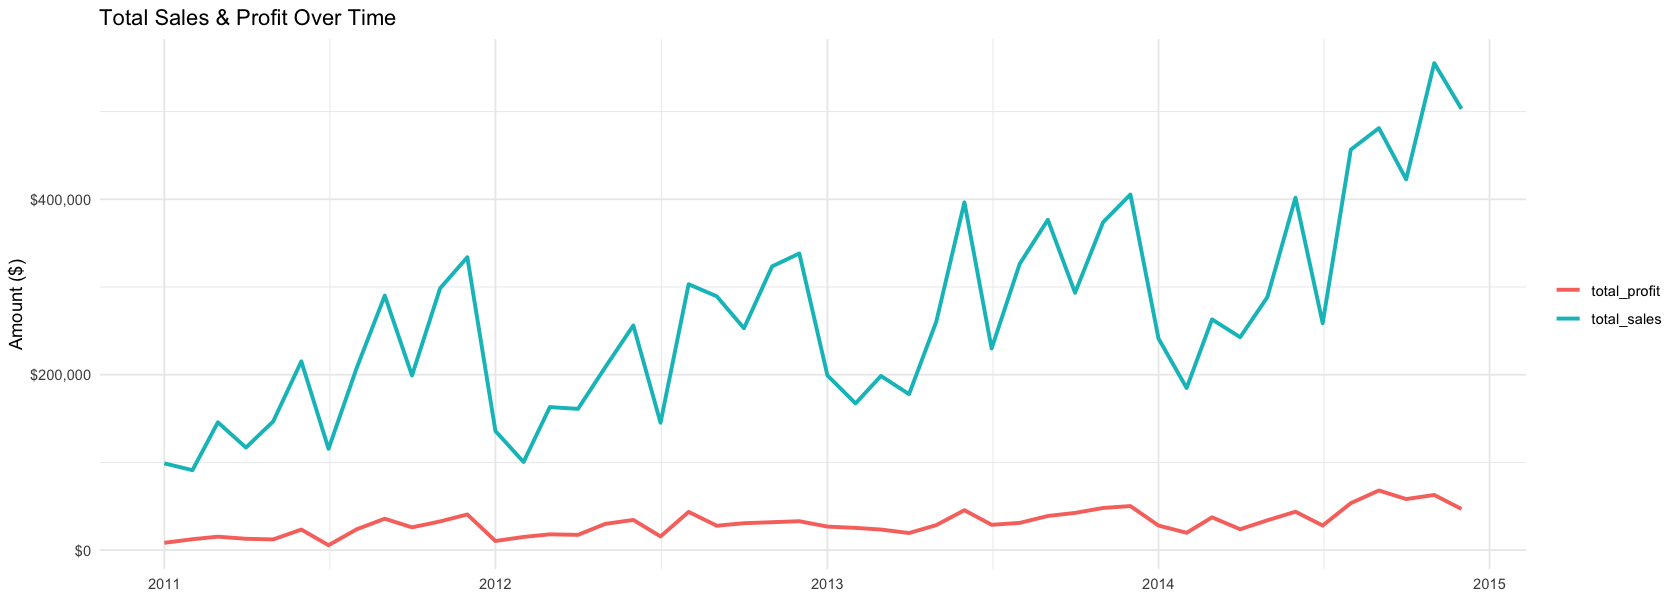

In [3]:
monthly_perf <- orders_monthly |> 
    group_by(month) |> 
    summarise(
        total_sales = sum(sales),
        total_profit = sum(profit),
        .groups = "drop"
    ) |> 
    pivot_longer(
        c(total_sales, total_profit),
        names_to = "metric",
        values_to = "value"
    )

ggplot(monthly_perf, aes(month, value, color = metric)) + 
    geom_line(linewidth = 1.1) + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Total Sales & Profit Over Time",
        x = NULL,
        y = "Amount ($)",
        color = NULL
    ) + 
    theme_minimal()

### Order volume vs average order value over time

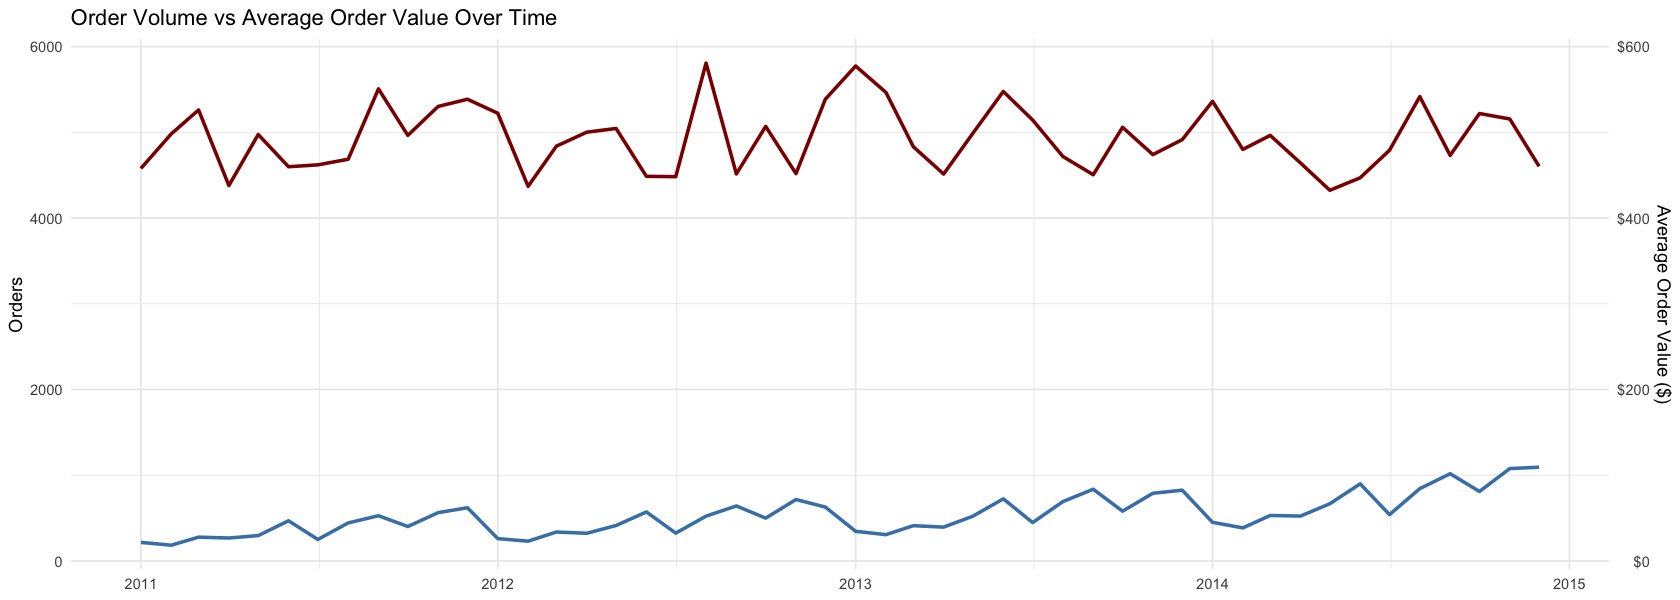

In [4]:
monthly_orders <- orders_monthly |> 
    group_by(month) |> 
    summarise(
        orders = n_distinct(order_id),
        sales = sum(sales),
        aov = sales / orders,
        .groups = "drop"
    )

ggplot(monthly_orders, aes(month)) + 
    geom_line(aes(y = orders), color = "steelblue", linewidth = 1) + 
    geom_line(aes(y = aov * 10), color = "darkred", linewidth = 1) + 
    scale_y_continuous(
        name = "Orders",
        sec.axis = sec_axis(
            ~ . / 10,
            name = "Average Order Value ($)",
            labels = scales::dollar_format()
        )
    ) + 
    labs(
        title = "Order Volume vs Average Order Value Over Time",
        x = NULL
    ) + 
    theme_minimal()

# Seasonality & Cycles

### Monthly seasonality (calendar view)

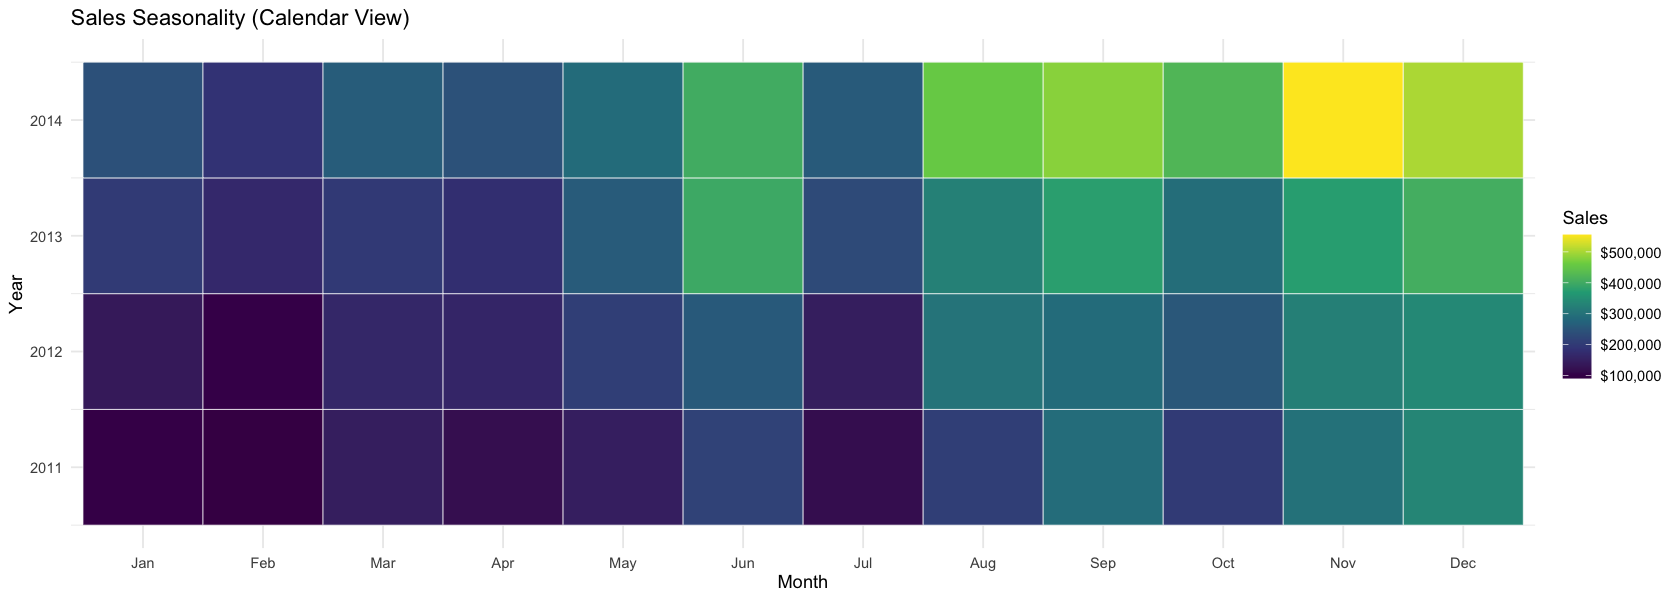

In [5]:
seasonality <- orders_monthly |> 
    mutate(
        year  = year(month),
        m     = month(month, label = TRUE)
    ) |> 
    group_by(year, m) |> 
    summarise(total_sales = sum(sales), .groups = "drop")

ggplot(seasonality, aes(m, year, fill = total_sales)) + 
    geom_tile(color = "white") + 
    scale_fill_viridis_c(labels = scales::dollar_format()) + 
    labs(
        title = "Sales Seasonality (Calendar View)",
        x = "Month",
        y = "Year",
        fill = "Sales"
    ) + 
    theme_minimal()

### Sales & profit seasonality side-by-side

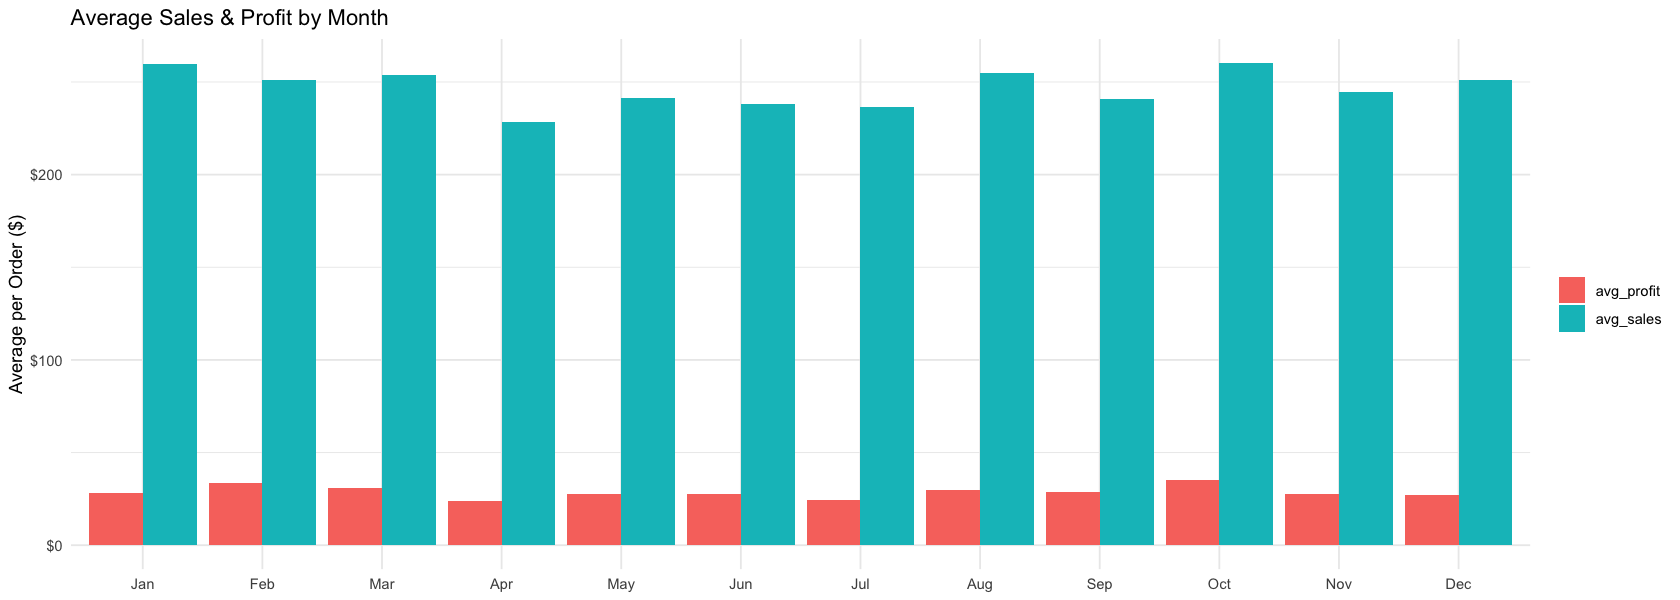

In [6]:
monthly_avg <- orders_monthly |> 
    mutate(m = month(order_date, label = TRUE)) |> 
    group_by(m) |> 
    summarise(
        avg_sales = mean(sales),
        avg_profit = mean(profit),
        .groups = "drop"
    ) |> 
    pivot_longer(-m, names_to = "metric", values_to = "value")

ggplot(monthly_avg, aes(m, value, fill = metric)) + 
    geom_col(position = "dodge") + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Average Sales & Profit by Month",
        x = NULL,
        y = "Average per Order ($)",
        fill = NULL
    ) + 
    theme_minimal()

# Structural Trend Decomposition

### STL / rolling trend for sales

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_line()`).”


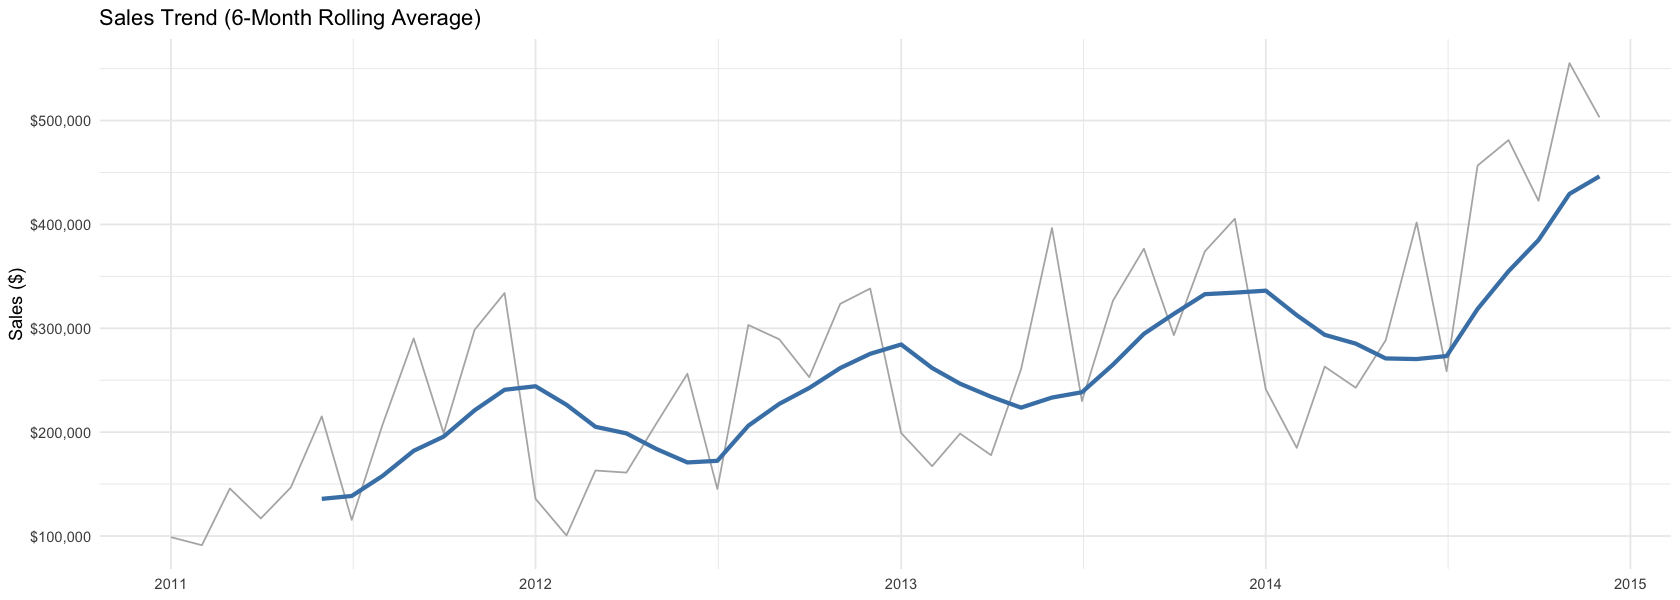

In [7]:
monthly_sales <- orders_monthly |> 
    group_by(month) |> 
    summarise(total_sales = sum(sales), .groups = "drop") |> 
    arrange(month) |> 
    mutate(
        rolling_6m = zoo::rollmean(total_sales, 6, fill = NA, align = "right")
    )

ggplot(monthly_sales, aes(month)) + 
    geom_line(aes(y = total_sales), color = "grey70") + 
    geom_line(aes(y = rolling_6m), color = "steelblue", linewidth = 1.2) + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Sales Trend (6-Month Rolling Average)",
        x = NULL,
        y = "Sales ($)"
    ) + 
    theme_minimal()

### Profit trend vs sales trend

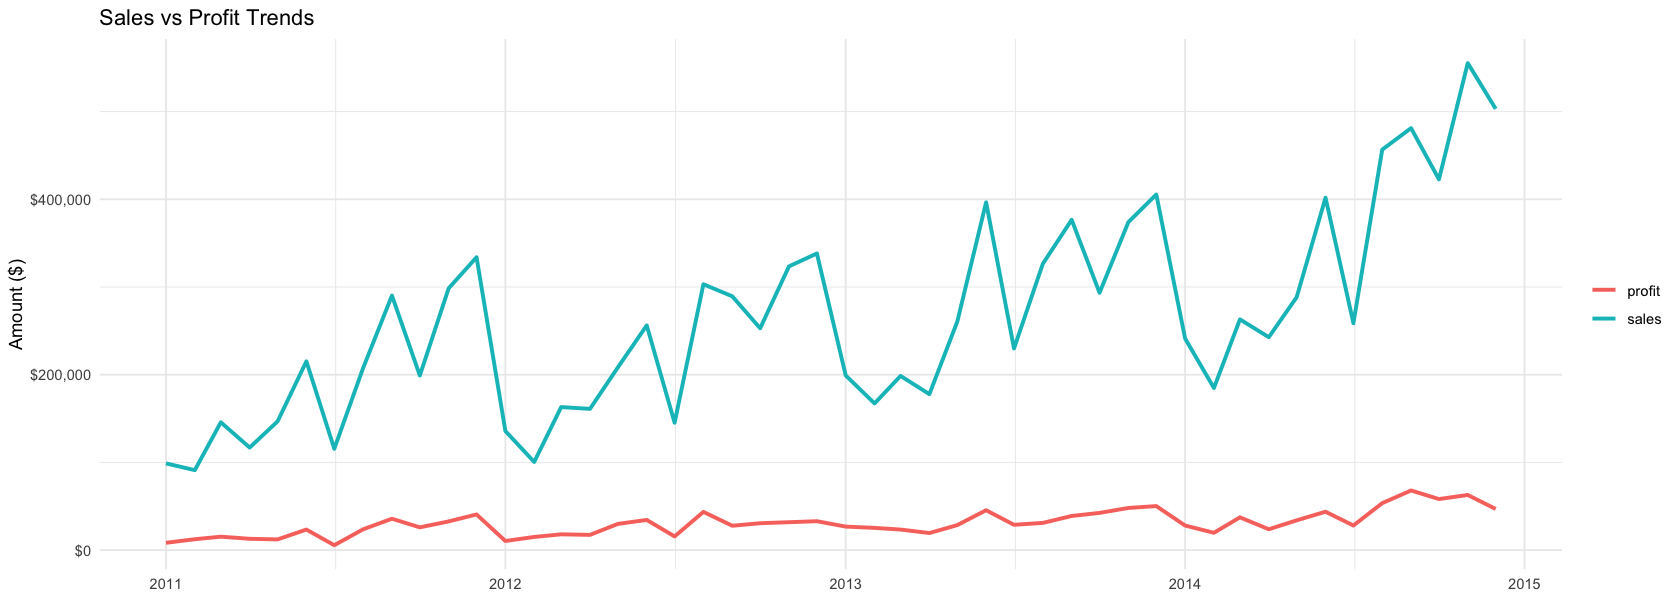

In [8]:
monthly_trends <- orders_monthly |> 
    group_by(month) |> 
    summarise(
        sales = sum(sales),
        profit = sum(profit),
        .groups = "drop"
    ) |> 
    pivot_longer(-month)

ggplot(monthly_trends, aes(month, value, color = name)) + 
    geom_line(linewidth = 1.1) + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(
        title = "Sales vs Profit Trends",
        x = NULL,
        y = "Amount ($)",
        color = NULL
    ) + 
    theme_minimal()

# Segment-Level Temporal Dynamics 

### Sales over time by segment (faceted)

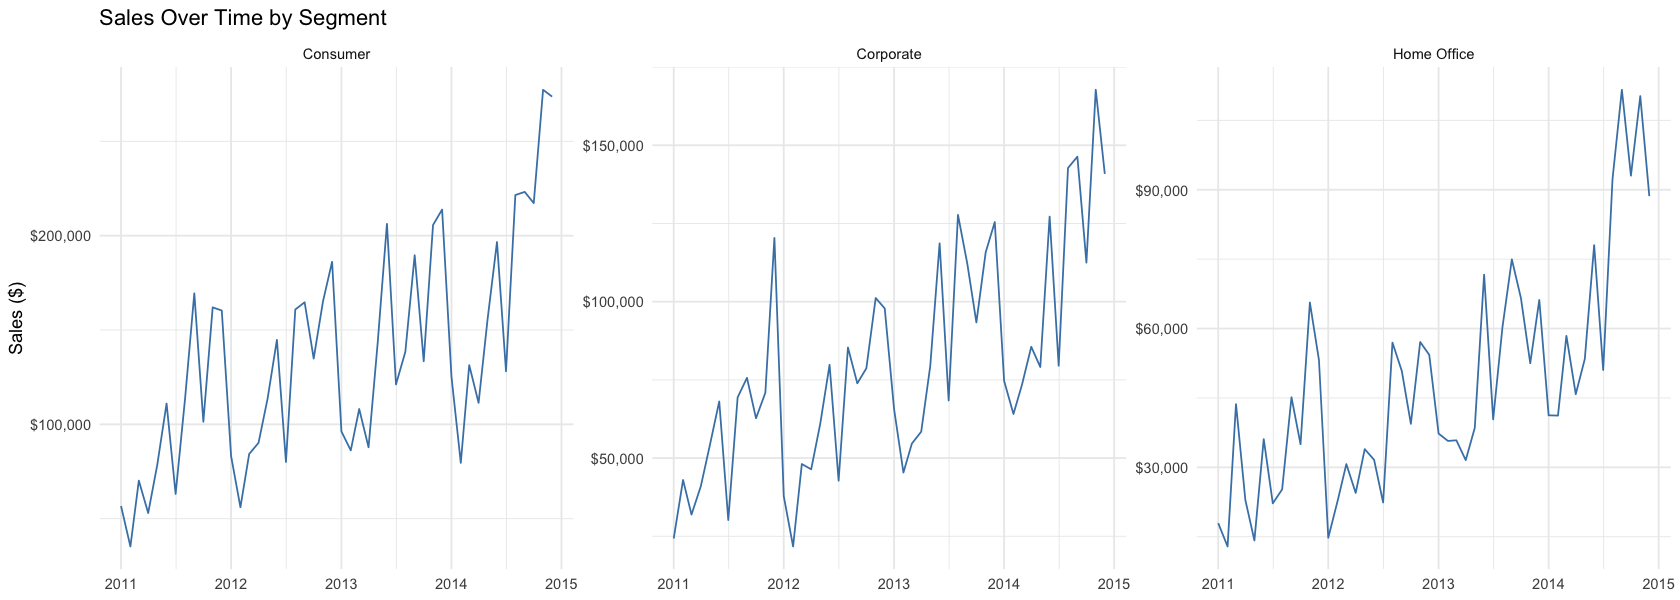

In [9]:
segment_time <- orders_monthly |> 
    group_by(month, segment) |> 
    summarise(sales = sum(sales), .groups = "drop")

ggplot(segment_time, aes(month, sales)) + 
    geom_line(color = "steelblue") + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    facet_wrap(~segment, scales = "free_y") + 
    labs(
        title = "Sales Over Time by Segment",
        x = NULL,
        y = "Sales ($)"
    ) + 
    theme_minimal()

### Segment share of total sales over time

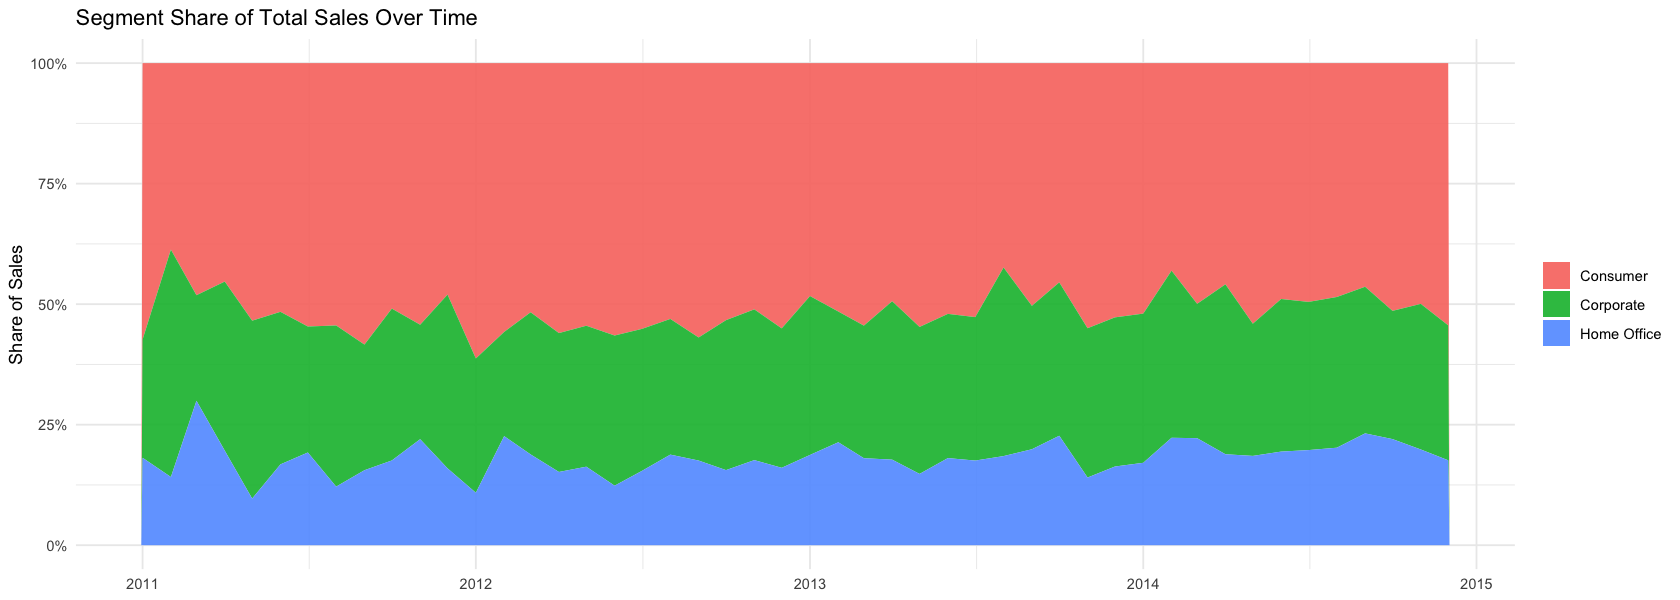

In [10]:
segment_share <- segment_time |> 
    group_by(month) |> 
    mutate(share = sales / sum(sales))

ggplot(segment_share, aes(month, share, fill = segment)) + 
    geom_area(alpha = 0.9) + 
    scale_y_continuous(labels = scales::percent_format()) + 
    labs(
        title = "Segment Share of Total Sales Over Time",
        x = NULL,
        y = "Share of Sales",
        fill = NULL
    ) + 
    theme_minimal()

# Product & Category Dynamics (relative change)

### Category share of total sales over time

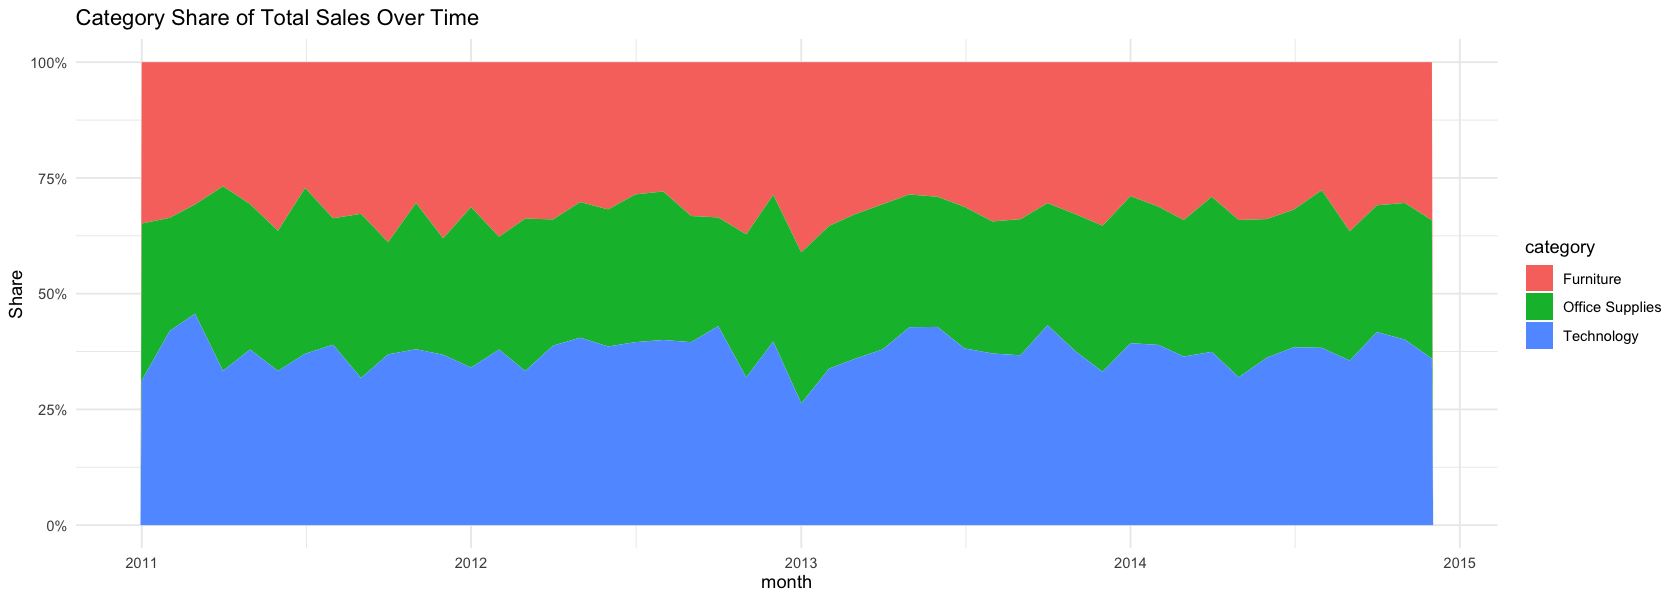

In [11]:
category_monthly <- orders |> 
    mutate(month = floor_date(order_date, "month")) |> 
    group_by(month, category) |> 
    summarise(sales = sum(sales), .groups = "drop") |> 
    group_by(month) |> 
    mutate(share = sales / sum(sales))

ggplot(category_monthly, aes(month, share, fill = category)) + 
    geom_area() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Category Share of Total Sales Over Time", 
        y = "Share"
    ) + 
    theme_minimal()

### Category profit margin over time

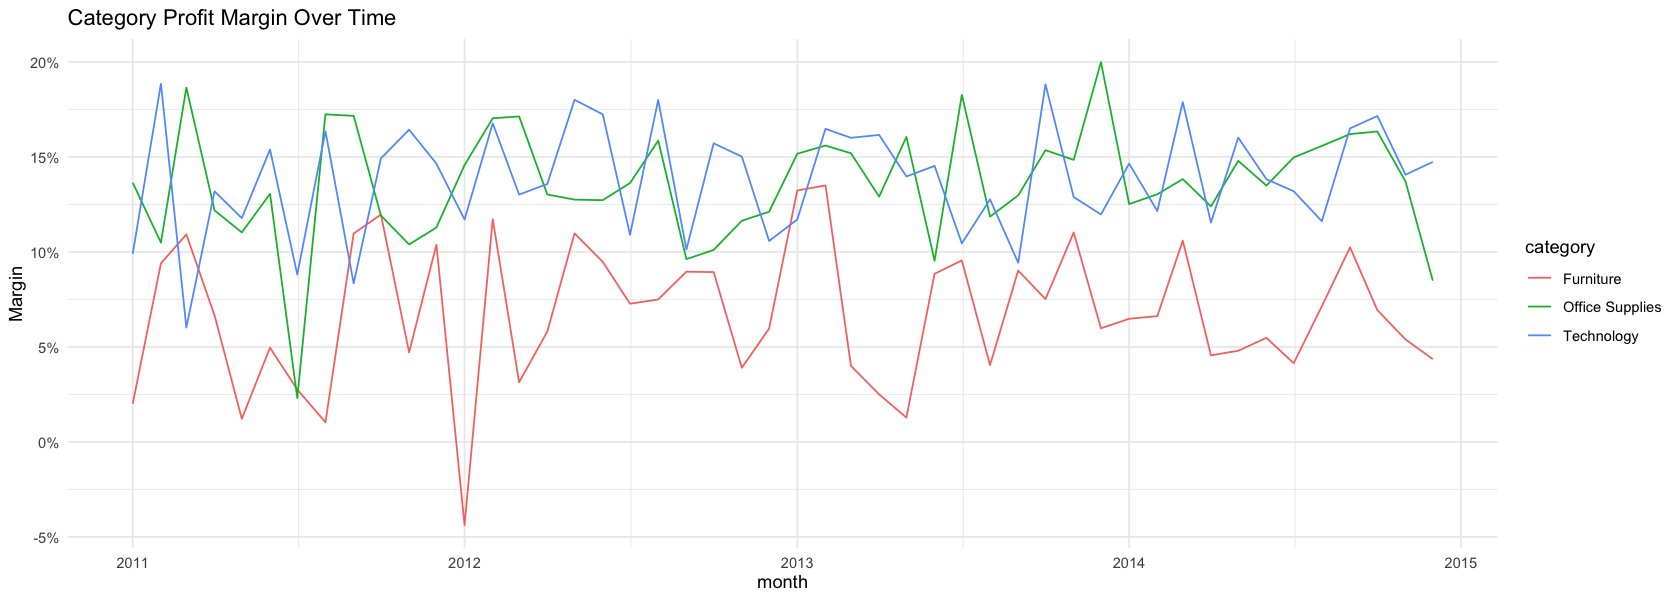

In [12]:
category_margin <- orders |> 
    mutate(month = floor_date(order_date, "month")) |> 
    group_by(month, category) |> 
    summarise(
        sales = sum(sales),
        profit = sum(profit),
        .groups = "drop"
    ) |> 
    mutate(margin = profit / sales)

ggplot(category_margin, aes(month, margin, color = category)) + 
    geom_line() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Category Profit Margin Over Time", 
        y = "Margin"
    ) + 
    theme_minimal()

# Volatility & Stability

### Rolling volatility of sales & profit (6 months)

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_line()`).”


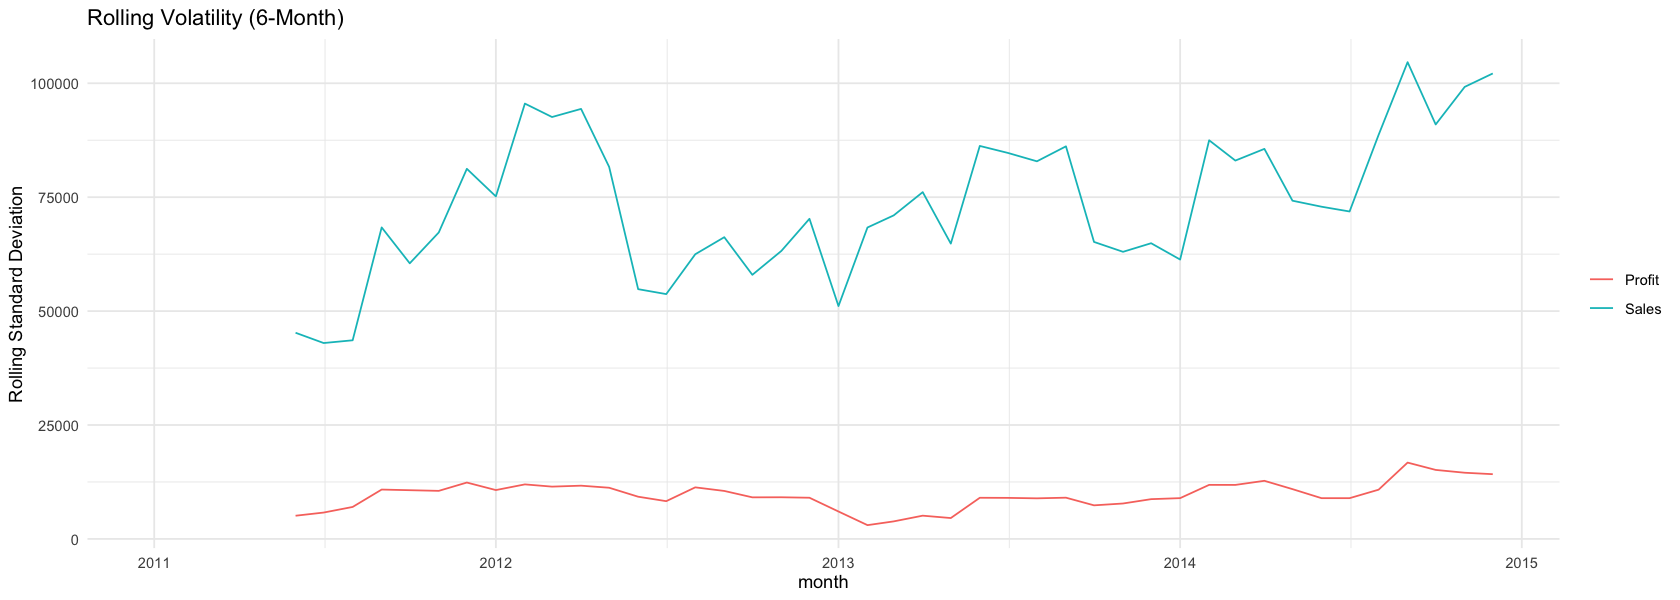

In [13]:
WINDOW <- 6

monthly <- orders |> 
    mutate(month = floor_date(order_date, "month")) |> 
    group_by(month) |> 
    summarise(
        sales = sum(sales),
        profit = sum(profit),
        .groups = "drop"
    ) |> 
    arrange(month) |> 
    mutate(
        sales_vol = purrr::map_dbl(
            seq_along(sales),
            ~ if (.x < WINDOW) {
                NA_real_
            } else {
                sd(sales[(.x - WINDOW + 1):.x])
            }
        ),
        profit_vol = purrr::map_dbl(
            seq_along(profit),
            ~ if (.x < WINDOW) {
                NA_real_
            } else {
                sd(profit[(.x - WINDOW + 1):.x])
            }
        )
    )

ggplot(monthly, aes(month)) + 
    geom_line(aes(y = sales_vol, color = "Sales")) + 
    geom_line(aes(y = profit_vol, color = "Profit")) + 
    labs(
        title = paste("Rolling Volatility (", WINDOW, "-Month)", sep = ""),
        y = "Rolling Standard Deviation",
        color = NULL
    ) + 
    theme_minimal()

### Profit margin distribution over time (yearly)

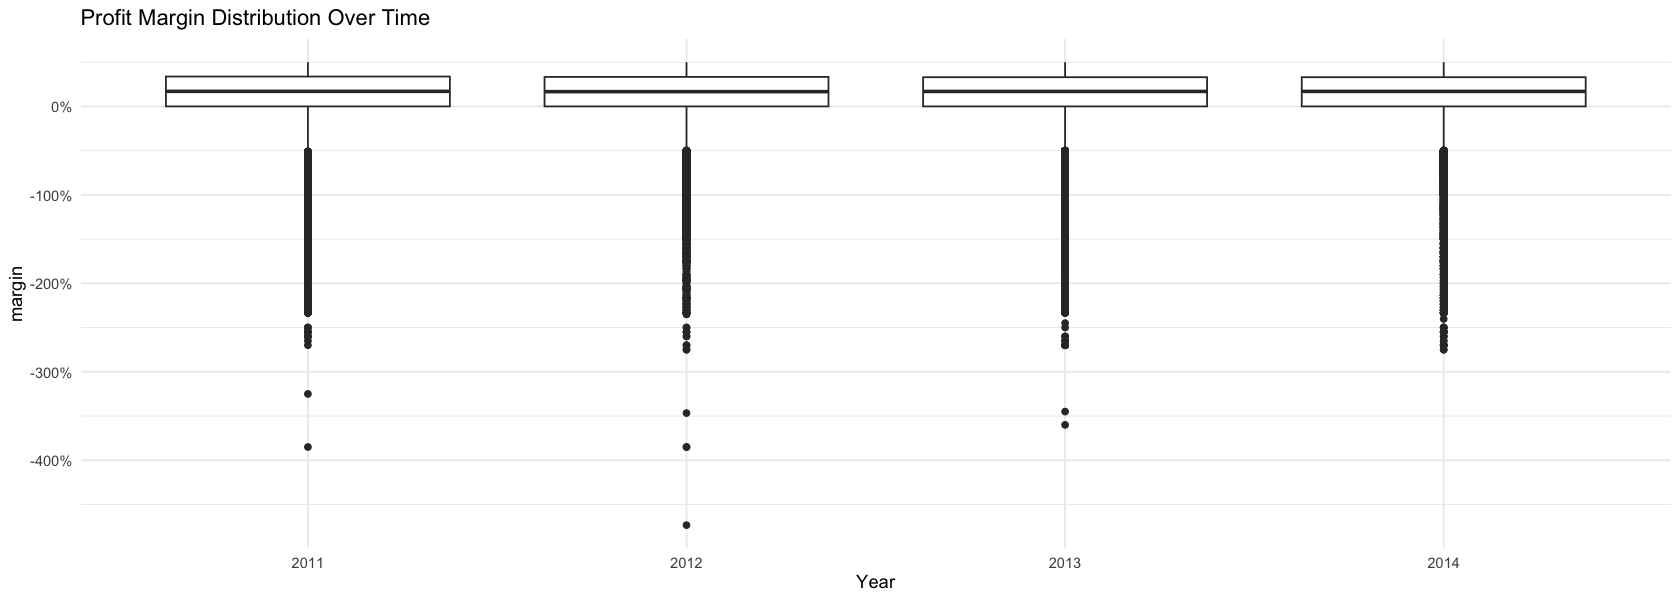

In [14]:
orders |> 
    mutate(year = year(order_date), margin = profit / sales) |> 
    ggplot(aes(factor(year), margin)) + 
    geom_boxplot() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Profit Margin Distribution Over Time", 
        x = "Year"
    ) + 
    theme_minimal()

# Return-Aware Temporal Trends

### Return rate over time

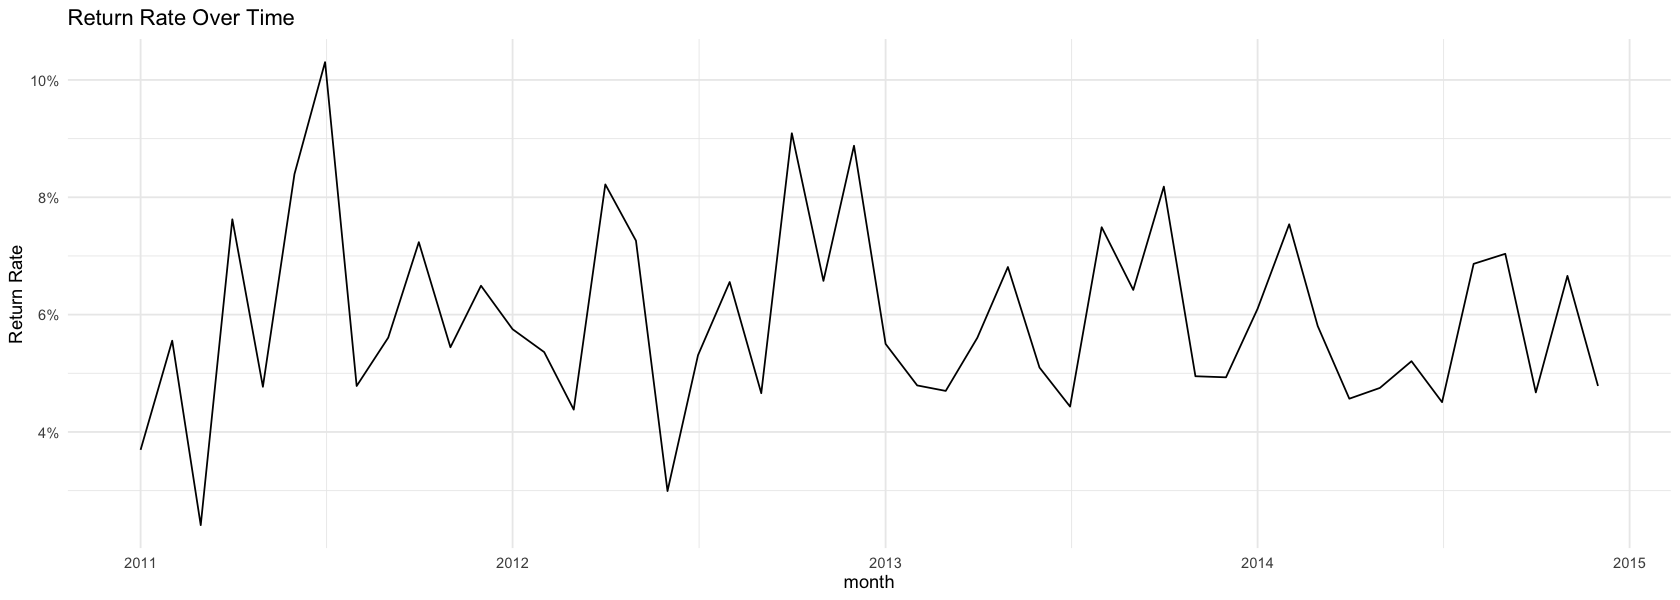

In [15]:
orders_with_returns <- orders |> 
    left_join(
        returns |> distinct(order_id) |> mutate(returned = 1),
        by = "order_id"
    ) |> 
    mutate(returned = if_else(is.na(returned), 0, returned))

orders_with_returns |> 
    mutate(month = floor_date(order_date, "month")) |> 
    group_by(month) |> 
    summarise(return_rate = mean(returned), .groups = "drop") |> 
    ggplot(aes(month, return_rate)) + 
    geom_line() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Return Rate Over Time", 
        y = "Return Rate"
    ) + 
    theme_minimal()

### Discount intensity over time

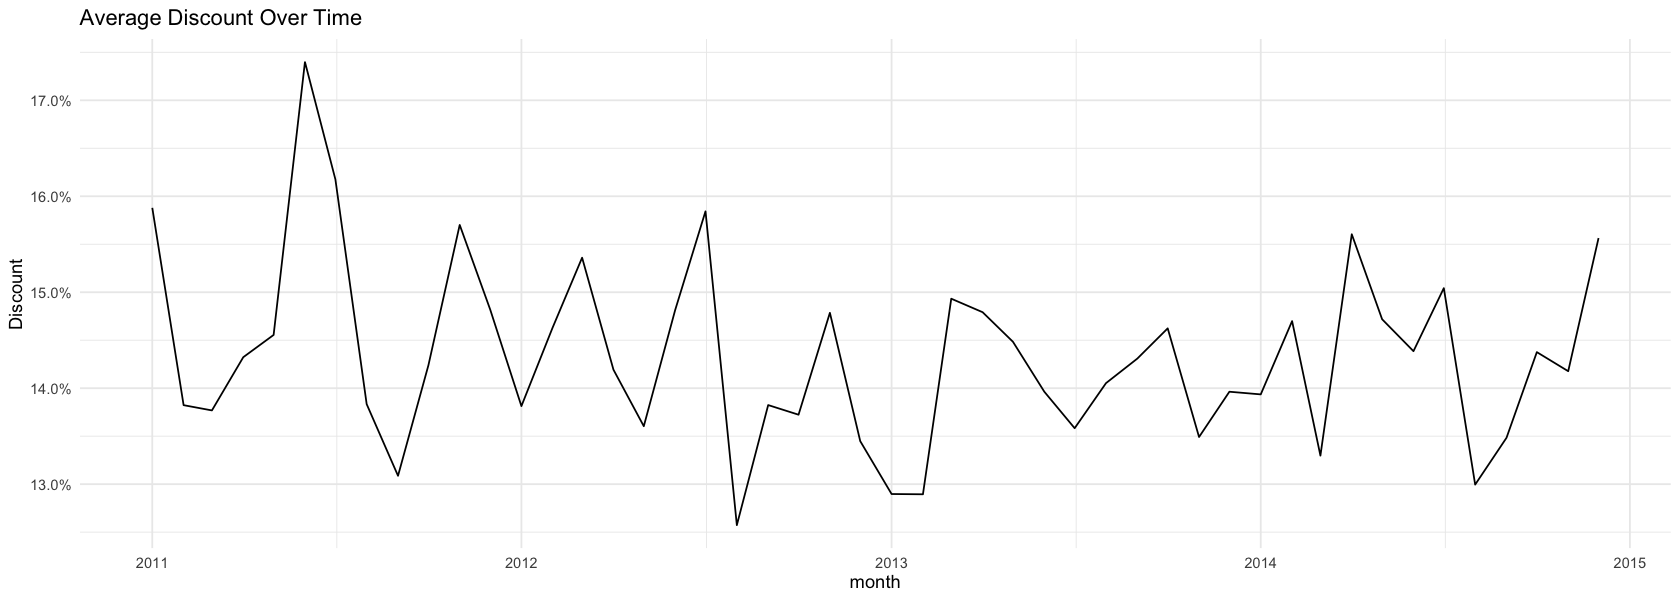

In [16]:
orders |> 
    mutate(month = floor_date(order_date, "month")) |> 
    group_by(month) |> 
    summarise(avg_discount = mean(discount), .groups = "drop") |> 
    ggplot(aes(month, avg_discount)) + 
    geom_line() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Average Discount Over Time", 
        y = "Discount"
    ) + 
    theme_minimal()

# Change Detection & Regimes

### Year-over-year growth rates (sales)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_col()`).”


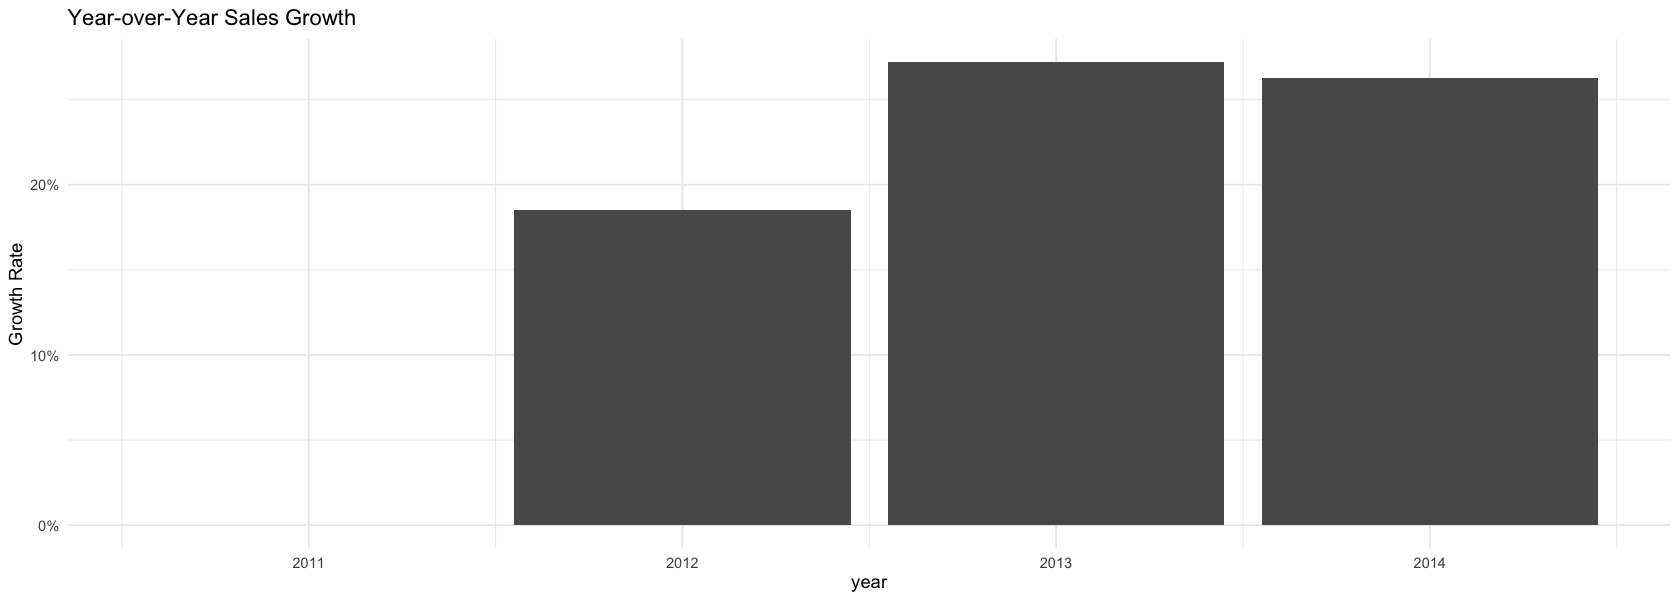

In [17]:
yoy <- orders |> 
    mutate(year = year(order_date)) |> 
    group_by(year) |> 
    summarise(sales = sum(sales), .groups = "drop") |> 
    arrange(year) |> 
    mutate(yoy_growth = (sales / lag(sales)) - 1)

ggplot(yoy, aes(year, yoy_growth)) + 
    geom_col() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Year-over-Year Sales Growth", 
        y = "Growth Rate"
    ) + 
    theme_minimal()

### Pre/post period comparison (2013)

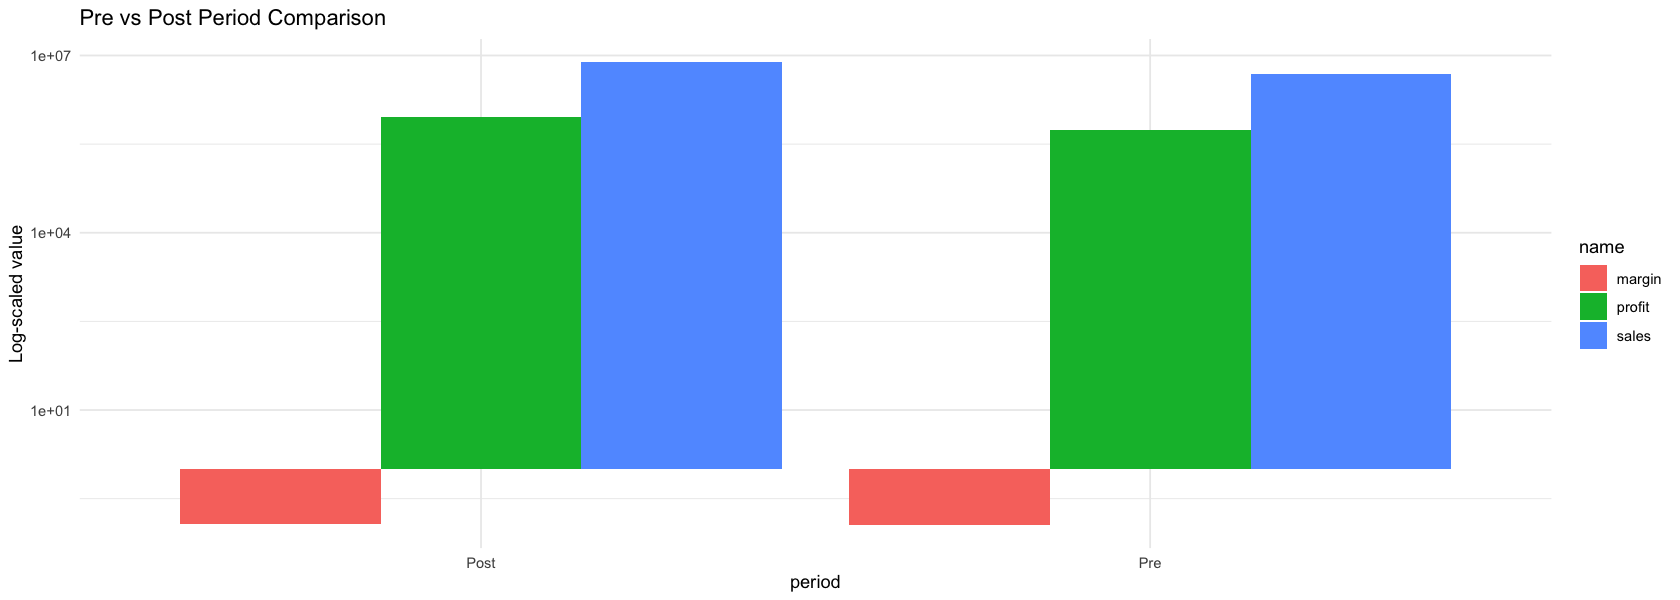

In [18]:
orders |> 
    mutate(period = if_else(order_date < as.Date("2013-01-01"), "Pre", "Post")) |> 
    group_by(period) |> 
    summarise(
        sales = sum(sales), 
        profit = sum(profit), 
        margin = profit / sales, 
        .groups = "drop"
    ) |> 
    pivot_longer(-period) |> 
    ggplot(aes(period, value, fill = name)) + 
    geom_col(position = "dodge") + 
    scale_y_continuous(trans = "log10") + 
    labs(
        title = "Pre vs Post Period Comparison", 
        y = "Log-scaled value"
    ) + 
    theme_minimal()